# House Prices Predictions with XGBoost

In [101]:
import warnings
from pathlib import Path
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor
import joblib

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.impute import SimpleImputer

warnings.filterwarnings("ignore") # mute warnings for cleaner output

## Load Dataset
Load the data into pandas dataframe

In [102]:
# Load data
df_train = pd.read_csv("data/train.csv").drop("Id", axis=1)
df_test = pd.read_csv("data/test.csv").drop("Id", axis=1)
df_train.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


## Data Visualization

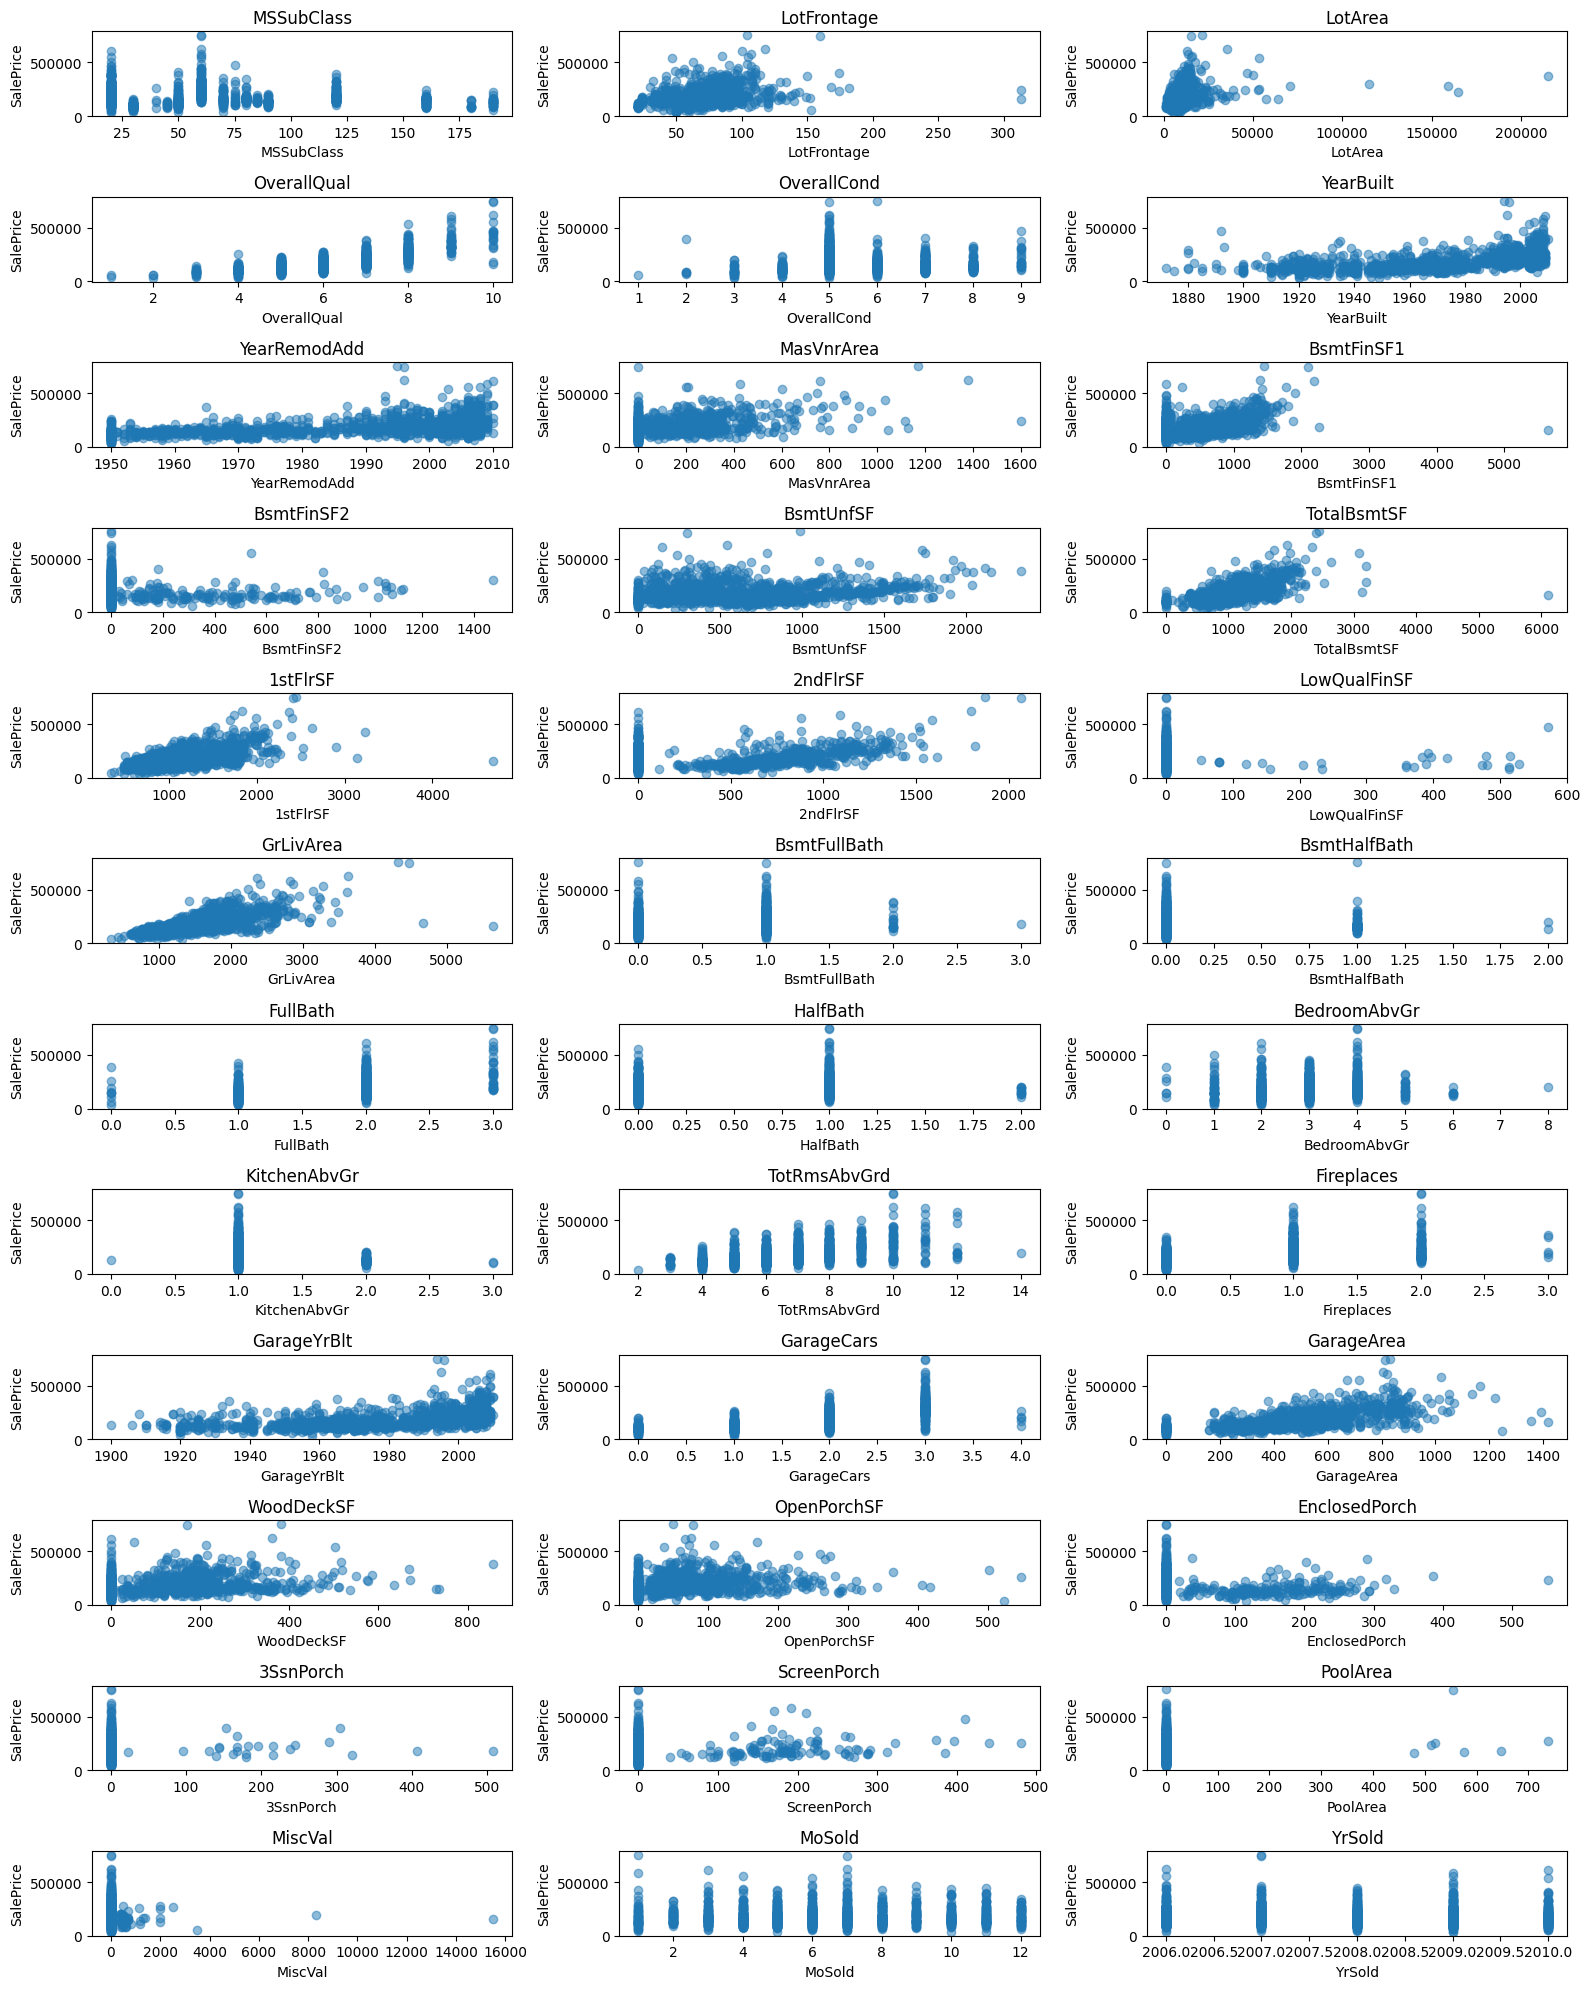

In [103]:
# Plot numerical features
df_num = df_train.select_dtypes(include=[np.number])
fig, axes = plt.subplots(
    nrows=int(len(df_num.columns) / 3),
    ncols=3,
    figsize=(16, 20)
)

axes = axes.flatten()

for ax, col in zip(axes, df_num.columns):
    if col != "SalePrice":
        ax.scatter(df_train[col], df_train["SalePrice"], alpha=0.5)
        ax.set_title(col)
        ax.set_xlabel(col)
        ax.set_ylabel("SalePrice")

plt.tight_layout()
plt.show()


<Axes: >

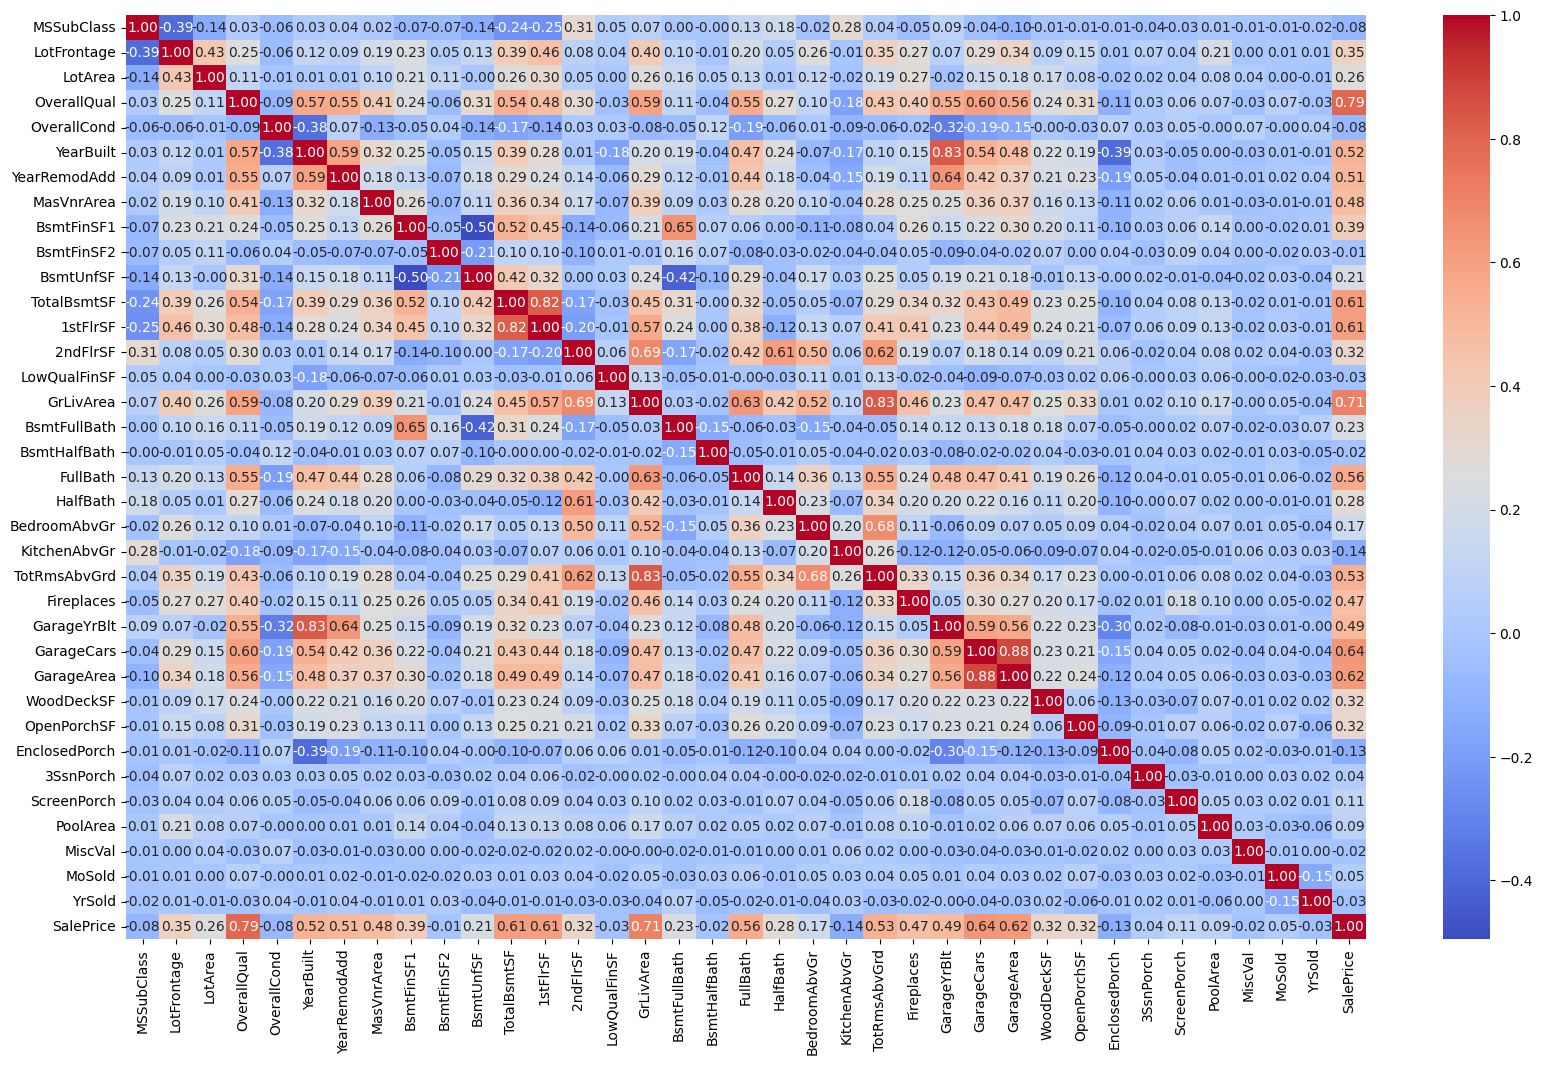

In [104]:
correlation_matrix = df_train.corr(numeric_only=True)
plt.figure(figsize=(20,12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

## Data Preparation

In [105]:
y = df_train["SalePrice"].values
X = df_train.drop("SalePrice", axis=1)

num_cols = X.select_dtypes(include=np.number).columns

# Sort out ode col with Chatbot as sorting it manually is tedious
ode_col = [
    "MSSubClass", "LotShape", "LandSlope",
    "Utilities", "OverallQual", "OverallCond", 
    "ExterQual", "ExterCond", "BsmtQual",
    "BsmtCond", "BsmtExposure", "BsmtFinType1",
    "BsmtFinType2", "HeatingQC", "CentralAir", 
    "Electrical", "KitchenQual", "Functional",
    "FireplaceQu", "GarageFinish", "GarageQual",
    "GarageCond", "PavedDrive", "PoolQC",
    "Fence",
]

ohe_col = X.select_dtypes(include="object").columns.difference(ode_col)


num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

ode_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ode', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
])

ohe_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

col_transformer = ColumnTransformer(transformers=[
    ('num_p', num_pipeline, num_cols),
    ('ode_p', ode_pipeline, ode_col),
    ('ohe_p', ohe_pipeline, ohe_col),
], remainder='passthrough', n_jobs=-1)

pipeline = Pipeline(steps=[
    ('preprocessor', col_transformer),
])

X_preprocessed = pipeline.fit_transform(X)

# Splitting train, cv and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_preprocessed,
    y,
    test_size=0.2,
    random_state=7
)

# Documentation for XGBoost Parameters: https://xgboost.readthedocs.io/en/stable/parameter.html
param_grid = {
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1],
    'learning_rate': [0.05, 0.1],
    'reg_lambda': [1, 5],
    'gamma': [0, 0.1, 0.2],
}

xgb_model = XGBRegressor(random_state=7)
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=3,
    n_jobs=-1,
    verbose=50
)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_score = -grid_search.best_score_ 
print("Best params:", best_params, "Best RMSE:", best_score)

Fitting 3 folds for each of 1620 candidates, totalling 4860 fits
[CV 2/3; 2/1620] START colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, reg_lambda=1, subsample=0.8
[CV 1/3; 3/1620] START colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, reg_lambda=1, subsample=0.9
[CV 2/3; 3/1620] START colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, reg_lambda=1, subsample=0.9
[CV 2/3; 2/1620] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, reg_lambda=1, subsample=0.8;, score=-27584.672 total time=   0.0s
[CV 2/3; 4/1620] START colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, reg_lambda=5, subsample=0.7
[CV 1/3; 3/1620] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, reg_lambda=1, subsample=0.9;, score=-30136.771 total time=   0.0s
[CV 3/3; 4/1620] START colsample_bytree=0.6, gamma=0,

In [106]:
final_model = XGBRegressor(**best_params, random_state=7)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)
rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
print("Test RMSE:", rmse)

Test RMSE: 23254.857075897744


## Save and load the model

In [107]:
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
joblib.dump(final_model, MODEL_PATH / "full_pipeline.pkl")

['models/full_pipeline.pkl']

In [108]:
final_model = joblib.load(MODEL_PATH / "full_pipeline.pkl")

In [111]:
df_test_preprocessed = pipeline.transform(df_test)
y_pred = final_model.predict(df_test_preprocessed)
df_xgb_pred = pd.DataFrame({
    "Id": range(len(df_train)+1,len(df_train)+len(df_test)+1),
    "SalePrice": y_pred,
})
df_xgb_pred.set_index("Id", inplace=True)
PRED_PATH = Path("data/xgb_pred.csv")
df_xgb_pred.to_csv(PRED_PATH)

## Visualize the prediction

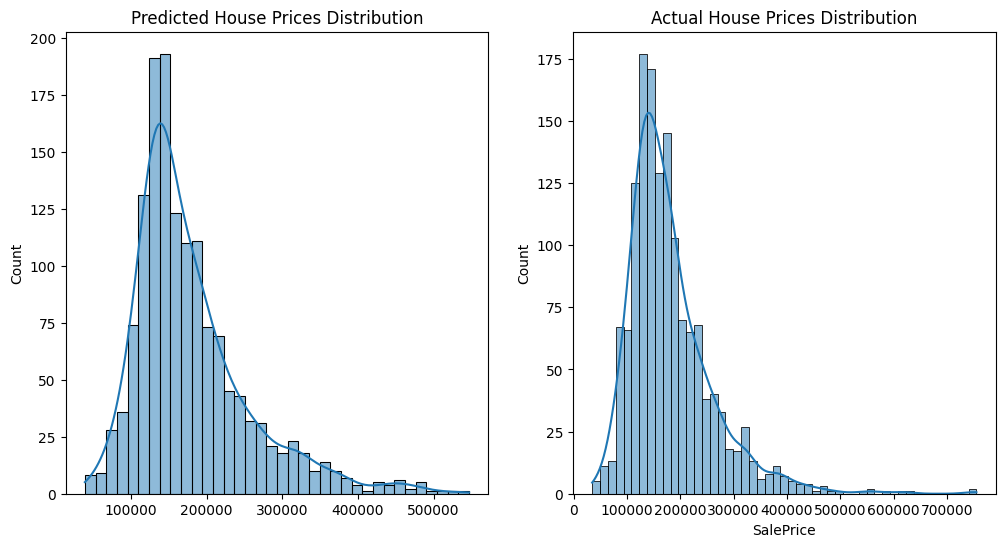

In [112]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
ax = sns.histplot(data=y_pred, kde=True).set(title="Predicted House Prices Distribution")
plt.subplot(1,2,2)
ax = sns.histplot(data=df_train["SalePrice"], kde=True).set(title="Actual House Prices Distribution")